In [1]:
#!pip install jais transformers datasets torch evaluate regex accelerate xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModel
from huggingface_hub import login

import regex as reg
import re
import ast
import torch

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
label_encoder = LabelEncoder()
AnxEncoder = LabelEncoder()
DepEncoder = LabelEncoder()
smote = SMOTE(random_state=42)
Sbert = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [3]:
def clean_text(text):
  cleaned = re.sub(r'[\'\"\n\d,;.،؛.؟{}():]', ' ', text)
  cleaned = re.sub(r'\s{2,}', ' ', cleaned)

  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F" # emoticons
  u"\U0001F300-\U0001F5FF" # symbols
  u"\U0001F680-\U0001F6FF" # transport & map symbols
  u"\U0001F1E0-\U0001F1FF" # flags
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  "]+", flags=re.UNICODE)
  cleaned = emoji_pattern.sub(r'', cleaned)
  cleaned = re.sub(r'[\u064B-\u0652]', '', cleaned) # tashkeel removal
  # Normalize -> Alif
  cleaned = re.sub(r'[إأآا]', 'ا', cleaned)
  # Normalization -> Ta Marbuta to Ha
  cleaned = cleaned.replace('ة', 'ه')
  # Normalization -> Yeh
  cleaned = cleaned.replace('ى', 'ي')
  cleaned = cleaned.replace("ؤ", "و")
  cleaned = cleaned.replace("ئ", "ي")
  cleaned = re.sub(r'[^\u0600-\u06FF\s]', '', cleaned) # punctuation and latin characters removal
  return cleaned.strip()

In [4]:
def up_sample(X, Y):
  return smote.fit_resample(X, Y)

In [5]:
def encode_Sbert(questions,answers):
  questions = [clean_text(text) for text in questions]
  #questions = [clean_and_stem_arabic(text) for text in questions]
  question_embeddings = Sbert.encode(questions, convert_to_tensor=True,normalize_embeddings=True)
  similarities = []
  for _, answer in answers.iterrows():
    answer = answer.tolist()
    answer_embedding = Sbert.encode([answer], convert_to_tensor=True, normalize_embeddings=True)

    # Compute cosine similarity to all question embeddings
    row_similarities = cosine_similarity(answer_embedding, question_embeddings)[0]  # returns 2D array
    similarities.append(row_similarities)
  df = pd.DataFrame(similarities, columns=[f"Q{i+1}_sim" for i in range(len(questions))])
  return df

In [6]:
def ConfusionMatrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

def LearningCurve(estimator, X, y, title=None):

    fig, ax = plt.subplots(figsize=(7, 5))

    LearningCurveDisplay.from_estimator(
        estimator,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
        score_type="both",
        n_jobs=4,
        line_kw={"marker": "o"},
        std_display_style="fill_between",
        score_name="Accuracy",
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(title or f"Learning Curve for {estimator.__class__.__name__}")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def get_score(model, X_test):
  return model.predict_proba(X_test)

In [9]:
def SVM(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42,probability=True)
  svm.fit(X_train, y_train)
  y_pred = svm.predict(X_test)
  y_prob = svm.predict_proba(X_test)
  roc_auc = roc_auc_score(y_test, y_prob[:, 1])
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("ROC AUC Score:", round(roc_auc, 4))
  print("\nClassification Report:\n", classification_report(y_test, y_pred, digits = 4))
  ConfusionMatrix(y_test, y_pred)
  LearningCurve(svm, X_train, y_train)
  svm_scores = get_score(svm, X_test)
  return svm, svm_scores

In [10]:
df = pd.read_excel("/content/final_tammeni_augmented_final.xlsx")
df.iloc[::,:6] = df.iloc[::,:6].astype(str).applymap(clean_text)


<ipython-input-10-a7a7893d8698>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[::,:6] = df.iloc[::,:6].astype(str).applymap(clean_text)


In [11]:
df = df[~df['Diagnosis'].apply(lambda x: "Another Disorder" in x)]
# depression
df_dep = df.iloc[::,[0,1,2,8]]
df_dep = df_dep[~df_dep['Diagnosis'].apply(lambda x: "Anxiety" in x)].reset_index(drop=True)
df_dep['Diagnosis'] = df_dep['Diagnosis'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
df_dep['Diagnosis'] = DepEncoder.fit_transform(df_dep['Diagnosis'])
# anxiety
df_anx = df.iloc[::,[2,3,4,5,8]]
df_anx = df_anx[~df_anx['Diagnosis'].apply(lambda x: "Depression" in x)].reset_index(drop=True)
df_anx['Diagnosis'] = df_anx['Diagnosis'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 1 else x)
df_anx = df_anx[~df_anx['Diagnosis'].apply(lambda x: 'Anxiety' in x and 'Healthy' in x)].reset_index(drop=True)
df_anx['Diagnosis'] = AnxEncoder.fit_transform(df_anx['Diagnosis'])

Accuracy: 0.8055555555555556
ROC AUC Score: 0.8047

Classification Report:
               precision    recall  f1-score   support

           0     0.7826    0.9000    0.8372        20
           1     0.8462    0.6875    0.7586        16

    accuracy                         0.8056        36
   macro avg     0.8144    0.7937    0.7979        36
weighted avg     0.8109    0.8056    0.8023        36



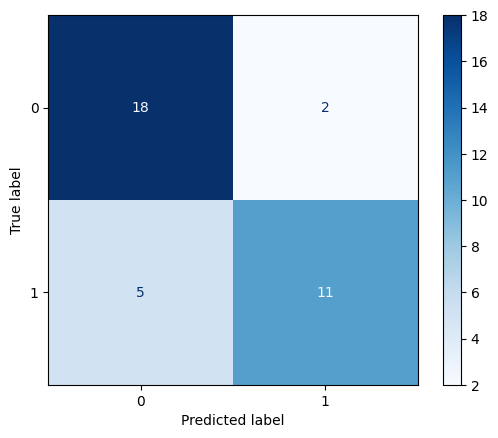

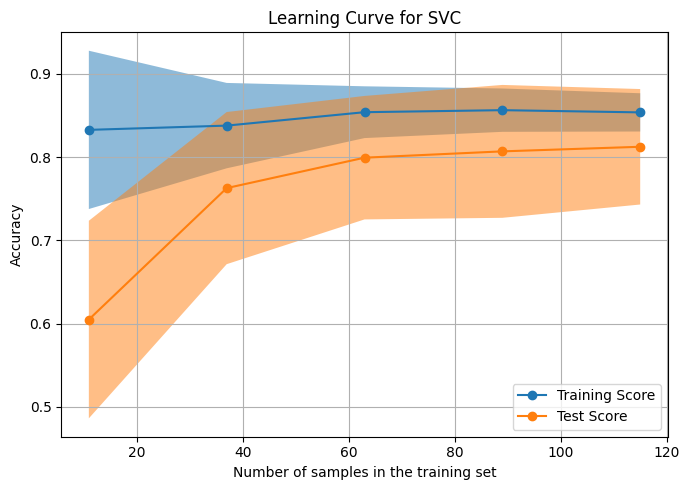

In [12]:
questions_dep = df_dep.columns.to_list()[:3]
answers_dep = df_dep[questions_dep]
X = encode_Sbert(questions_dep, answers_dep)
y = df_dep['Diagnosis']
X, y = up_sample(X, y)
svm_dep, SVMDepScore = SVM(X,y)

Accuracy: 0.6875
ROC AUC Score: 0.7461

Classification Report:
               precision    recall  f1-score   support

           0     0.8750    0.4375    0.5833        16
           1     0.6250    0.9375    0.7500        16

    accuracy                         0.6875        32
   macro avg     0.7500    0.6875    0.6667        32
weighted avg     0.7500    0.6875    0.6667        32



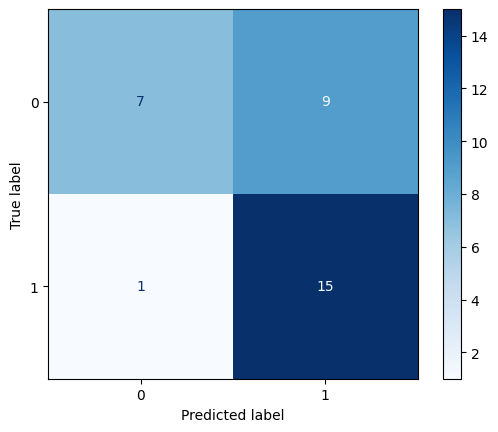

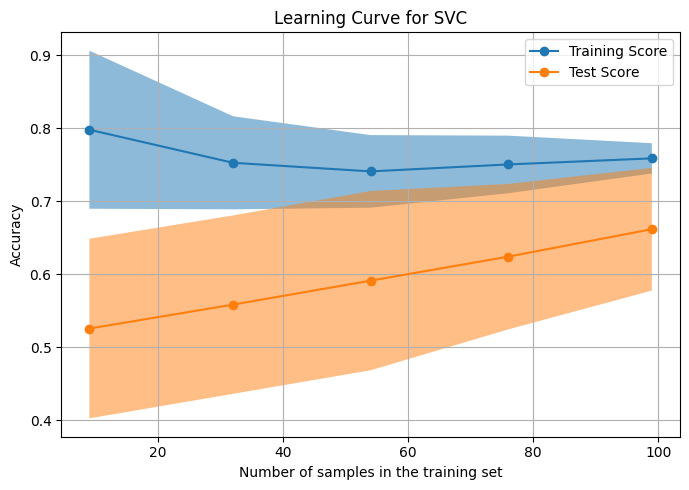

In [13]:
questions_anx = df_anx.columns.to_list()[:4]
answers_anx = df_anx[questions_anx]
X = encode_Sbert(questions_anx, answers_anx)
y = df_anx['Diagnosis']
X, y = up_sample(X, y)
svm_anx, SVMAnxScore = SVM(X,y)